<a href="https://colab.research.google.com/github/amadousysada/scoring-model/blob/master/03_modelisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="text-align:center; font-size:3.3em; color:#AD7D67; line-height:5rem; font-style:italic; font-weight:700;">
    Projet N°4 : <br>
    Implémentation d'un modèle de scoring </p>
<p style="text-align:center; font-size:2.8em; color:#9EBEB8; line-height:4rem; font-style:italic; font-weight:700;">
    IV - Modélisation
</p>

# Sommaire


1.   [Introduction](#introduction)
2.   [Import des Librairies](li)
3.   [Préparation des données](#preparation-des-donnees)
  - 3.1.  [Chargement des données]()
  - 3.2.  [Séparation des données (train et test)]()
4.   [Exploration des modéles](#modelisation)
  - 4.1.  [Dummy Classifier]()
  - 4.2.  [RandomForest]()
  - 4.3.  [Logistic Regression]()
  - 4.4.  [LightGBM]()
  - 4.5.  [XGBoost]()
  - 4.6.  [Naive Baise]()
5.   [Comparaison des modéles](#comparaison)
6.   [Optimisation du modéle LighGBM]()


# **1. Introduction**

L’objectif de cette modélisation est de construire un modèle de machine learning optimisé, capable de minimiser les pertes financières tout en maintenant une précision élevée. Pour ce faire, nous avons adopté une méthodologie rigoureuse, incluant la préparation des données, l’évaluation de plusieurs algorithmes et la sélection du modèle le plus performant.  

Étant donné la nature déséquilibrée des données (peu de cas de défaut comparés aux non-défauts), un équilibrage des classes est effectué grâce à la méthode **SMOTE** (Synthetic Minority Oversampling Technique). Cela permet de générer artificiellement des exemples minoritaires afin de garantir une répartition équitable entre les classes.  

Plusieurs modèles seront testés, allant d’un modèle de base, le **Dummy Classifier**, à des algorithmes avancés comme **Random Forest**, **Logistic Regression**, **LightGBM**, **XGBoost**, et **Naive Bayes**. Les performances des modèles sont évaluées à l’aide de plusieurs métriques, chacune offrant un éclairage spécifique sur la qualité des prédictions :  

- **AUC (Area Under the Curve)** : mesure la capacité d’un modèle à distinguer les classes, avec une valeur de 1 indiquant une parfaite séparation.  
- **F1-Score** : représente l’équilibre entre précision (precision) et rappel (recall) avec la formule :  
  **F1 = 2 × (precision × recall) / (precision + recall)**  
- **Précision (Precision)** : proportion de prédictions positives correctes parmi toutes les prédictions positives :  
  **Precision = TP / (TP + FP)**  
- **Rappel (Recall)** : capacité du modèle à identifier les cas positifs :  
  **Recall = TP / (TP + FN)**  
- **F2-Score** : variante du F1-Score, mettant davantage l’accent sur le rappel :  
  **F2 = (1 + 2²) × (precision × recall) / (2² × precision + recall)**  
- **Exactitude (Accuracy)** : proportion de prédictions correctes parmi toutes les prédictions :  
  **Accuracy = (TP + TN) / (TP + FP + FN + TN)**  
- **Score métier** : une métrique personnalisée pénalisant plus fortement les faux négatifs (FN) que les faux positifs (FP), avec la formule :  
  **Score métier = 10 × FN + FP**  

Ces métriques permettent une évaluation multidimensionnelle des performances des modèles, en tenant compte des implications métier et des aspects purement techniques. À l’issue de cette étude, une comparaison détaillée des résultats nous permettra de sélectionner le modèle offrant le meilleur compromis entre précision, rappel et minimisation des pertes financières.

# **2. Import des Librairies**

In [171]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)

In [172]:
# Forcer l'installation de la version 1.5.2 pour palier à une regression de scikit-learn qui impacte la librairie xgboost
# Line vers l'issue https://github.com/scikit-learn/scikit-learn/issues/30479

!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)


In [173]:
!pip install optuna

In [174]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import pickle
import optuna

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Scikit Learn
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, auc, make_scorer, confusion_matrix, fbeta_score, ConfusionMatrixDisplay, recall_score, precision_score
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibrationDisplay
from sklearn.compose import ColumnTransformer

# Modèles de Boosting
import lightgbm as lgbm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Imblearn, pour le réequilibrage
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# **3. Préparation des données**


Le nettoyage des données, comprenant le traitement des valeurs manquantes, des outliers et des incohérences, a été effectué dans un notebook dédié en amont. Cette étape garantit que les données utilisées ici sont déjà prêtes pour les étapes suivantes.  

Dans cette phase, nous nous concentrons sur la préparation des données pour la modélisation. Cela inclut le chargement des données et leur division en ensembles d’entraînement et de validation

## 3.1 Chargement des données

In [175]:
folder_path = "/content/drive/MyDrive/data/" # A ajuster selon le chemin où se trouve vos cvs.

In [176]:
X_train = pd.read_csv(f"{folder_path}final_cleaned_app_train.csv")
X_test = pd.read_csv(f"{folder_path}final_cleaned_app_test.csv")

In [177]:
X_train.drop(columns=['SK_ID_CURR'], inplace=True)
X_test.drop(columns=['SK_ID_CURR'], inplace=True)

In [178]:
X_train['TARGET'].isna().sum()

0

In [179]:
# Fonction pour afficher le diagramme en camembert
def plot_pie_chart(values, classes, title, ax):
    #plt.figure(figsize=(6, 6))
    ax.pie(values, labels=classes, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'orange'])
    ax.set_title(title)

TARGET
0    282686
1     24825
Name: count, dtype: int64


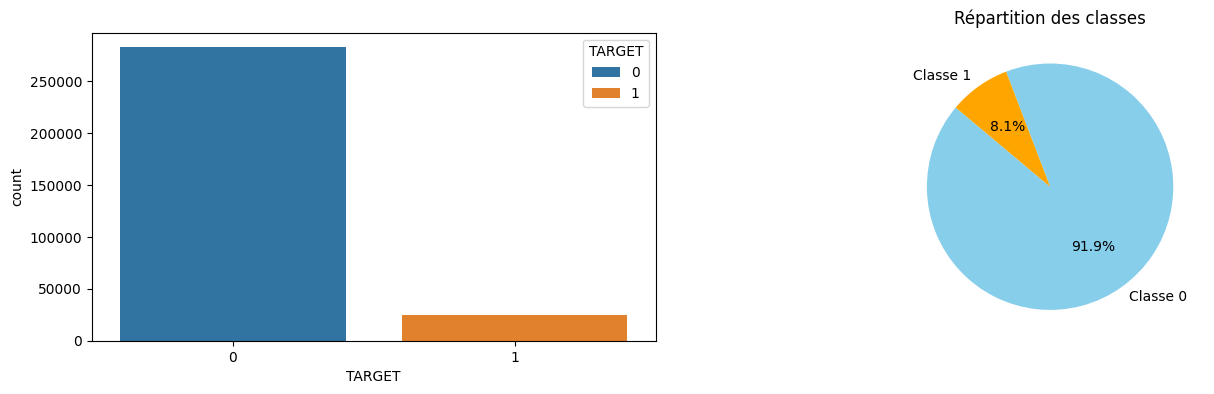

In [180]:
print(X_train.TARGET.value_counts())
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 4))
plot_pie_chart(X_train.TARGET.value_counts(), ['Classe 0', 'Classe 1'], "Répartition des classes", ax1)
sns.countplot(data=X_train.TARGET.to_frame(), x='TARGET', ax=ax0, hue='TARGET')
xticks = ax0.xaxis.get_ticks_position()
ax0.xaxis.set_ticks([0, 1])
plt.show()

In [181]:
# Le ratio du desequilibre
print(f"imbalance_ratio = {24825 / 282686:.2%}")

imbalance_ratio = 8.78%


## 3.2 Séparation des données (train et test)

In [182]:
# Séparation de l'ensemble X_train en 2 sous-ensembles
y = X_train['TARGET']
X_train.drop(labels='TARGET', axis=1, inplace=True)
X_Xtrain, X_valid, y_train, y_valid = train_test_split(X_train, y, stratify=y, test_size=0.3, random_state=42)
X_Xtrain.shape, X_valid.shape

((215257, 37), (92254, 37))

# **4. Exploration des modéles**


Dans cette section, nous explorons différents algorithmes de classification pour évaluer leur performance sur notre problématique. Chaque modèle appartient à une famille spécifique d’algorithmes, ce qui justifie son inclusion dans l’analyse. Les modèles ont été choisis pour couvrir une variété d’approches et de techniques d’apprentissage supervisé.  

1. **Dummy Classifier**  
   Ce modèle de base sert de référence. Il attribue les classes selon une règle simple (par exemple, prédire toujours la classe majoritaire) sans chercher à apprendre des données. Il permet de mesurer si les modèles plus complexes apportent une réelle valeur ajoutée.  

2. **Random Forest**  
   Appartenant à la famille des algorithmes d’ensemble, Random Forest combine plusieurs arbres de décision pour réduire la variance et améliorer la robustesse. Ce modèle est particulièrement performant pour capturer des relations non linéaires dans les données.  

3. **Logistic Regression**  
   Modèle linéaire appartenant à la famille des algorithmes paramétriques. Il est simple, rapide et efficace pour des données où les relations entre variables indépendantes et la cible sont approximativement linéaires.  

4. **LightGBM (Light Gradient Boosting Machine)**  
   Modèle d’ensemble basé sur le boosting, LightGBM est optimisé pour être rapide et efficace, même avec des données volumineuses. Il gère bien les interactions complexes entre les variables.  

5. **XGBoost (Extreme Gradient Boosting)**  
   Également un algorithme de boosting, XGBoost est connu pour ses performances élevées et sa capacité à exploiter pleinement les relations complexes dans les données. Il est souvent utilisé dans les compétitions de data science.  

6. **Naive Bayes**  
   Modèle probabiliste basé sur le théorème de Bayes, il est particulièrement adapté pour les données textuelles et les distributions simples. Bien qu’il repose sur une hypothèse forte d’indépendance entre les variables, il est inclus pour sa rapidité et sa simplicité.  

Ces modèles couvrent une large gamme d’approches, allant des méthodes de base aux algorithmes d’ensemble complexes, pour garantir une évaluation approfondie et diversifiée des performances.

In [183]:
# Fonction pour calculer le coût métier
def business_cost(y_true, y_pred_proba, threshold_return=False):
    """
    Calcule le coût métier en fonction des faux négatifs et faux positifs.

    Paramètres :
    y_true (array-like) : Les vraies étiquettes (0 ou 1).
    y_pred_proba (array-like) : Les probabilités de la classe positive (1).
    threshold_return : Si True, retourne le seuil optimal avec le score.

    Retourne :
    float : Le score métier normalisé (entre 0 et 1).
    """

    thresholds = np.arange(0.2, 1, 0.01)  # Seuils de 0.1 à 1 avec un pas de 0.01

    # Calcul de la prévalence des classes
    prevalence_positive = np.sum(y_true == 1) / len(y_true)  # Prévalence de la classe positive (défauts)
    prevalence_negative = np.sum(y_true == 0) / len(y_true)  # Prévalence de la classe négative (bons payeurs)

    # Calcul du coût maximal
    # Coût maximal : tout est mal classé (FN = nombre de défauts, FP = nombre de bons payeurs)
    max_cost = (10 * np.sum(y_true == 1)) + np.sum(y_true == 0)
    max_weighted_cost = max_cost / (prevalence_positive + prevalence_negative)

    best_score = -float('inf')
    best_threshold = 0.5
    for threshold in thresholds:
      y_pred_binary = (y_pred_proba >= threshold).astype(int)
      tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()

      cost = 10*fn + fp  # Coût métier brut

      # Pondération par la prévalence des classes
      weighted_cost = cost / (prevalence_positive + prevalence_negative)

      # Normalisation du coût (simplifié car min_weighted_cost = 0)
      normalized_score = 1 - (weighted_cost / max_weighted_cost)

      if normalized_score > best_score:
            best_score = normalized_score
            best_threshold = threshold

    if threshold_return:
        return best_score, best_threshold

    return best_score

# Scorer pour le coût métier
business_scorer = make_scorer(business_cost, response_method="predict_proba", greater_is_better=True)

## 4.1. Dummy Classifier

Metric accuray: 0.9192663732737876
Metric roc_auc: 0.5
Metric f1: 0.0
Metric Metier: 0.5324133947741798
Matrice de confusion:
[[84806     0]
 [ 7448     0]]


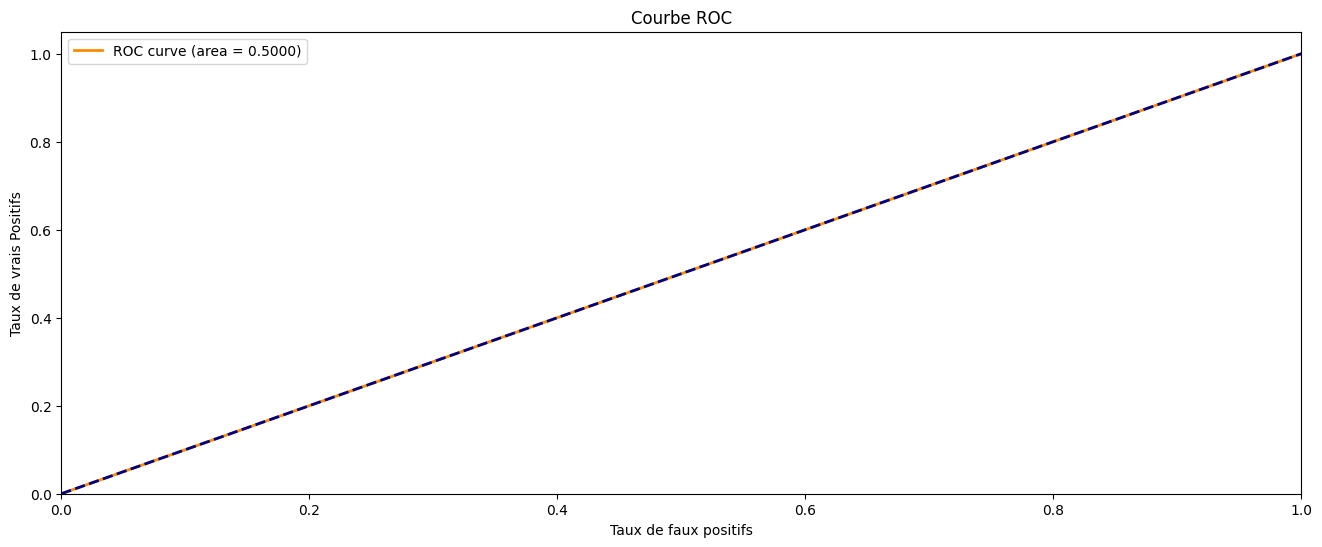

In [184]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)

dummy_clf.fit(X_Xtrain, y_train)

# Prédictions
y_pred = dummy_clf.predict(X_valid)
y_prob = dummy_clf.predict_proba(X_valid)[:, 1]

# Calcul des métriques
accuracy = accuracy_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_prob)
f1 = f1_score(y_valid, y_pred)

# Metric metier
cost = business_scorer(dummy_clf, X_valid, y_valid)

conf_matrix = confusion_matrix(y_valid, y_pred)

print(f"Metric accuray: {accuracy}")
print(f"Metric roc_auc: {roc_auc}")
print(f"Metric f1: {f1}")
print(f"Metric Metier: {cost}")

print(f"Matrice de confusion:\n{conf_matrix}")

fpr, tpr, _ = roc_curve(y_valid, y_prob)
roc_auc = auc(fpr, tpr)

fig = plt.figure(figsize=(16, 6))

# Visualiser la courbe ROC AUC
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais Positifs')
plt.title('Courbe ROC')
plt.legend(loc="upper left")
plt.show()

In [185]:
# Résultats des modèles
model_results = {}
import os
if os.path.exists(f"{folder_path}grid_search_results.pkl"):
    with open(f"{folder_path}grid_search_results.pkl", "rb") as f:
        model_results = pickle.load(f)

In [186]:
def get_preprocessor(data):
  if not isinstance(data, pd.DataFrame):
    data = pd.DataFrame(data, columns=X_Xtrain.columns)
  non_binary_cols = data.columns[data.nunique() > 2]

  preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), non_binary_cols)  # Appliquer seulement sur les colonnes non binaire
    ],
    remainder='passthrough'
  )
  return preprocessor

In [187]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42, n_jobs=-1),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, n_jobs=-1),
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1),
    "Naive Bayes": GaussianNB()
}

weights = np.linspace(0.0, 0.99, 4)

# Grilles d'hyperparamètres
param_grids = {
    "Logistic Regression": {
        "model__C": [0.01, 0.1, 1, 10],
        "model__penalty": ["l2"],
    },
    "Random Forest": {
        "model__n_estimators": [10, 100],
        "model__max_depth": [3, 6],
    },
    "XGBoost": {
        "model__n_estimators": [104, 117],
        "model__learning_rate": [0.05, 0.2],
        "model__max_depth": [5, 6],
    },
    "LightGBM": {
        "model__n_estimators": [118, 119],
        "model__learning_rate": [0.01, 0.20],
        "model__max_depth": [5, 6],
        #"model__scale_pos_weight": [0.5, 10]
    },
    "Naive Bayes": {
        "model__var_smoothing": [1e-9, 1e-8, 1e-7]
    }
}

scoring = {
  "business_score": business_scorer,
  "AUC": "roc_auc",
  "F1": "f1",
  "Accuracy": "accuracy",
  "Recall": "recall",
  "Precision": "precision",
  "F2": make_scorer(fbeta_score, beta=2)
}


def evaluate_model(model_name, X_train, y_train, X_valid, y_valid, force=True):
  """
  Entrainer un modèle, prédire sur l'ensemble de validation et évaluer les performances.

  Paramètres :
  model_name : Le nom modèle à entraîner.
  X_train, y_train : Les données d'entraînement.
  X_valid, y_valid : Les données de validation.
  force : Si True, force l'entraînement du modèle même si les résultats existent déjà.

  Retourne :
  obj: Les résultats de l'évaluation du modèle.
  """
  print(f"Évaluation du modèle : {model_name}")

  # Smote
  smote = SMOTE(random_state=42, k_neighbors=2, sampling_strategy=0.15)

  if model_name == "Logistic Regression":
    preprocessor = get_preprocessor(X_train)
    pipeline = ImbPipeline(
        steps=[
            ("scaler", preprocessor),
            ("imputer", SimpleImputer(strategy="median")),
            ("smote", smote),
            ("model", models["Logistic Regression"])
        ]
    )
  else:
    pipeline = ImbPipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("smote", smote),
            ("model", models[model_name])
        ]
    )

  cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

  params = param_grids[model_name]

  # GridSearchCV
  grid_search = GridSearchCV(
      pipeline,
      param_grid=params,
      scoring=scoring,
      refit="business_score",  # Optimisation basée sur le score métier
      cv=cv,
      verbose=1,
      return_train_score=True
  )

  # Entraînement
  if force or model_name not in model_results:
    grid_search.fit(X_train, y_train)
    model_results[model_name] = grid_search
  else:
    grid_search = model_results[model_name]

  # Sauvegarder les resultats, pour eviter plus tard le coùt de calcul
  with open(f"{folder_path}grid_search_results.pkl", "wb") as f:
    pickle.dump(model_results, f)

  y_pred = grid_search.predict(X_valid)
  y_prob = grid_search.predict_proba(X_valid)[:, 1]

  # Résultats
  print("Meilleurs paramètres :", grid_search.best_params_)
  print("Meilleur score métier :", grid_search.best_score_)

  fpr, tpr, _ = roc_curve(y_valid, y_prob)
  auc_score = roc_auc_score(y_valid, y_prob)

  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6))

  # Récupérer les scores pour chaque combinaison d'hyperparamètres
  scores = grid_search.cv_results_['mean_test_business_score']
  params = grid_search.cv_results_['params']

  # Visualiser notre score metier
  ax0.plot(range(len(scores)), scores, marker='o')
  ax0.set_title("Score métier pour chaque combinaison d'hyperparamètres")
  ax0.set_xlabel("Index de la combinaison d'hyperparamètres")
  ax0.set_ylabel("Score métier (plus bas est meilleur)")
  ax0.set_xticks(range(len(scores)), labels=[str(p) for p in params], rotation=90)
  ax0.grid(True)

  # Visualiser la courbe ROC AUC sur les données de validation
  show_roc_curve(fpr, tpr, auc_score, ax1, title='Validation data')

  # Visualiser la courbe ROC AUC sur les données d'entrainement
  y_train_prob = grid_search.predict_proba(X_train)[:, 1]
  train_fpr, train_tpr, _ = roc_curve(y_train, y_train_prob)
  auc_score = roc_auc_score(y_train, y_train_prob)
  show_roc_curve(train_fpr, train_tpr, auc_score, ax1, color='darkred', title='Training data')

  plt.show()

  print("-" * 50)
  return grid_search


def show_roc_curve(fpr, tpr, auc_score, ax, color='darkorange', title=''):
  ax.plot(fpr, tpr, color=color, lw=2, label=f"ROC curve {title} (area = {auc_score:.4f})")
  ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.0])
  ax.set_xlabel('Taux de faux positifs')
  ax.set_ylabel('Taux de vrais Positifs')
  ax.set_title('Courbe ROC')
  ax.legend(loc="upper left")

def visualize_confusion_matrix(model, X_valid, y_valid, scaler=None, classes=['non_defaut_payment(0)', 'defaut_payment(1)']):
  data = X_valid

  if scaler:
    data = pd.DataFrame(scaler.fit_transform(X_valid), columns=X_valid.columns)

  sklearn.set_config(enable_metadata_routing=True)
  score, threshold = business_scorer(model, data, y_valid, threshold_return=True)
  sklearn.set_config(enable_metadata_routing=False)
  print(f"Score métier : {score}")
  print(f"Meilleur seuil : {threshold}")
  print("---"*20)
  predictions = model.predict(data)
  cm = confusion_matrix(y_valid, predictions, labels=model.classes_)
  display(cm)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  disp.plot()
  plt.xlabel('Prédictions')
  plt.ylabel('Vraies étiquettes')
  plt.title('Matrice de confusion')
  plt.show()

def show_calibration_curve(models, X_valid, y_valid):
  fig = plt.figure(figsize=(16, 10))
  gs = GridSpec(7, 3)
  colors = plt.get_cmap("Dark2")

  ax_calibration_curve = fig.add_subplot(gs[:2, :2])
  calibration_displays = {}
  markers = ["^", "v", "s", "o", "2"]
  for i, (name,clf) in enumerate(models.items()):
      #clf.fit(X_train, y_train)
      display = CalibrationDisplay.from_estimator(
          clf,
          X_valid,
          y_valid,
          n_bins=10,
          name=name,
          ax=ax_calibration_curve,
          color=colors(i),
          marker=markers[i],
      )
      calibration_displays[name] = display

  ax_calibration_curve.grid()
  ax_calibration_curve.set_title("Calibration plots")

  # histogram
  grid_positions = [(3, 0), (3, 1), (3, 2), (5, 0), (5, 1)]
  for i, (name, _) in enumerate(models.items()):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

  plt.show()

## 4.2. RandomForest

Évaluation du modèle : Random Forest
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Meilleurs paramètres : {'model__max_depth': 6, 'model__n_estimators': 100}
Meilleur score métier : 0.5894738866268454


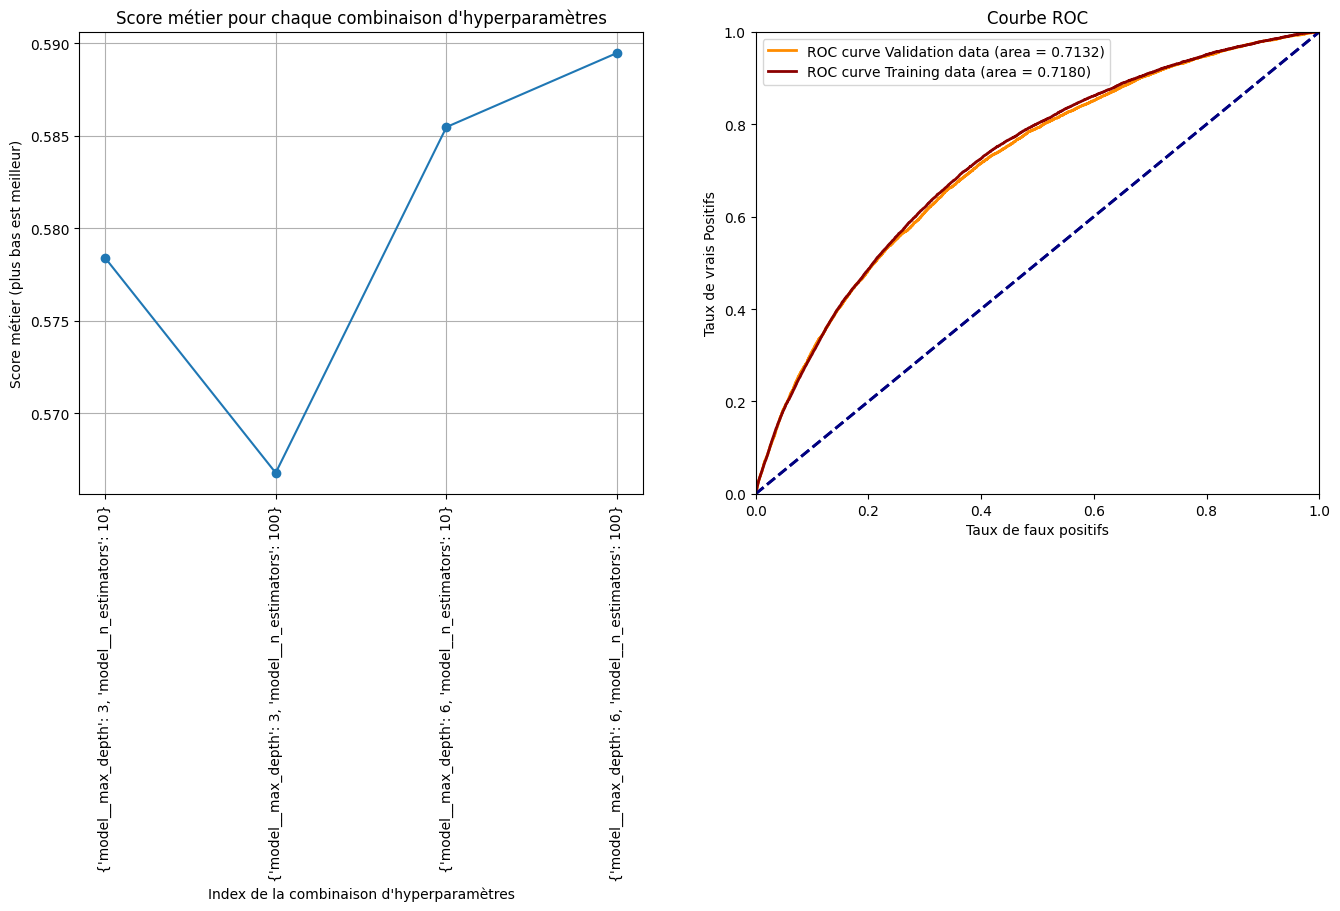

--------------------------------------------------
CPU times: user 7min 6s, sys: 4.9 s, total: 7min 11s
Wall time: 5min 2s


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('smote',
                                        SMOTE(k_neighbors=2, random_state=42,
                                              sampling_strategy=0.15)),
                                       ('model',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             param_grid={'model__max_depth': [3, 6],
                         'model__n_estimators': [10, 100]},
             refit='business_score', return_train_score=True,
             scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy', 'F1': 'f1',
                      'F2': make_scorer(fbeta_score, response_method='predict', beta=2),
                      'Precision': 'precision', 'Recall': 'recall',
                      'business_score': make_scorer(business_cost, response_method='predict_proba')},
             verbose=1)

In [188]:
%%time
evaluate_model(model_name='Random Forest', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=False)

Score métier : 0.5925756186984418
Meilleur seuil : 0.2
------------------------------------------------------------


array([[84806,     0],
       [ 7448,     0]])

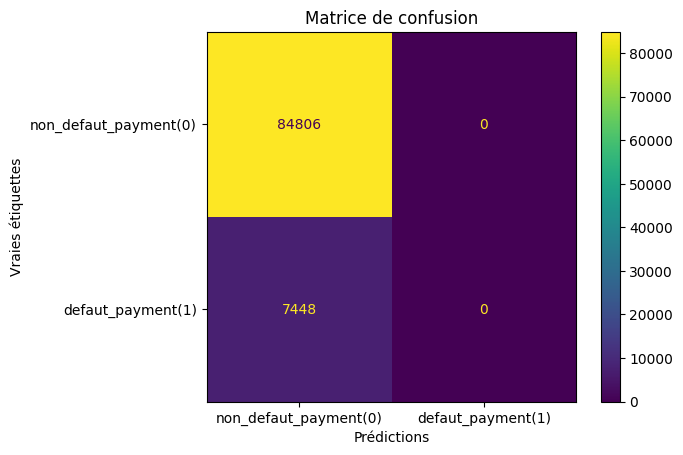

In [189]:
visualize_confusion_matrix(model_results['Random Forest'].best_estimator_, X_valid, y_valid)

Le modéle avec **Random Forest** montre une bonne capacité à capturer les classes positives **(69,670 TP)**, ce qui est essentiel dans un problème de risque de défaut de paiement. Cependant, le nombre élevé de **FN (15,136)** impacte le score métier négativement.

Le modèle présente un bon compromis entre sensibilité et précision, avec un nombre relativement bas de **FP (10,215)**. Cela reflète une bonne gestion des erreurs de classe négative (classe 0).

Random Forest est performant et équilibre correctement la réduction des FN et FP. Cependant, un nombre significatif de FN suggère que ce modèle peut encore être optimisé pour minimiser davantage les risques métier.

## 4.3 Logistic Regression

Évaluation du modèle : Logistic Regression
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Meilleurs paramètres : {'model__C': 1, 'model__penalty': 'l2'}
Meilleur score métier : 0.6584178564807948


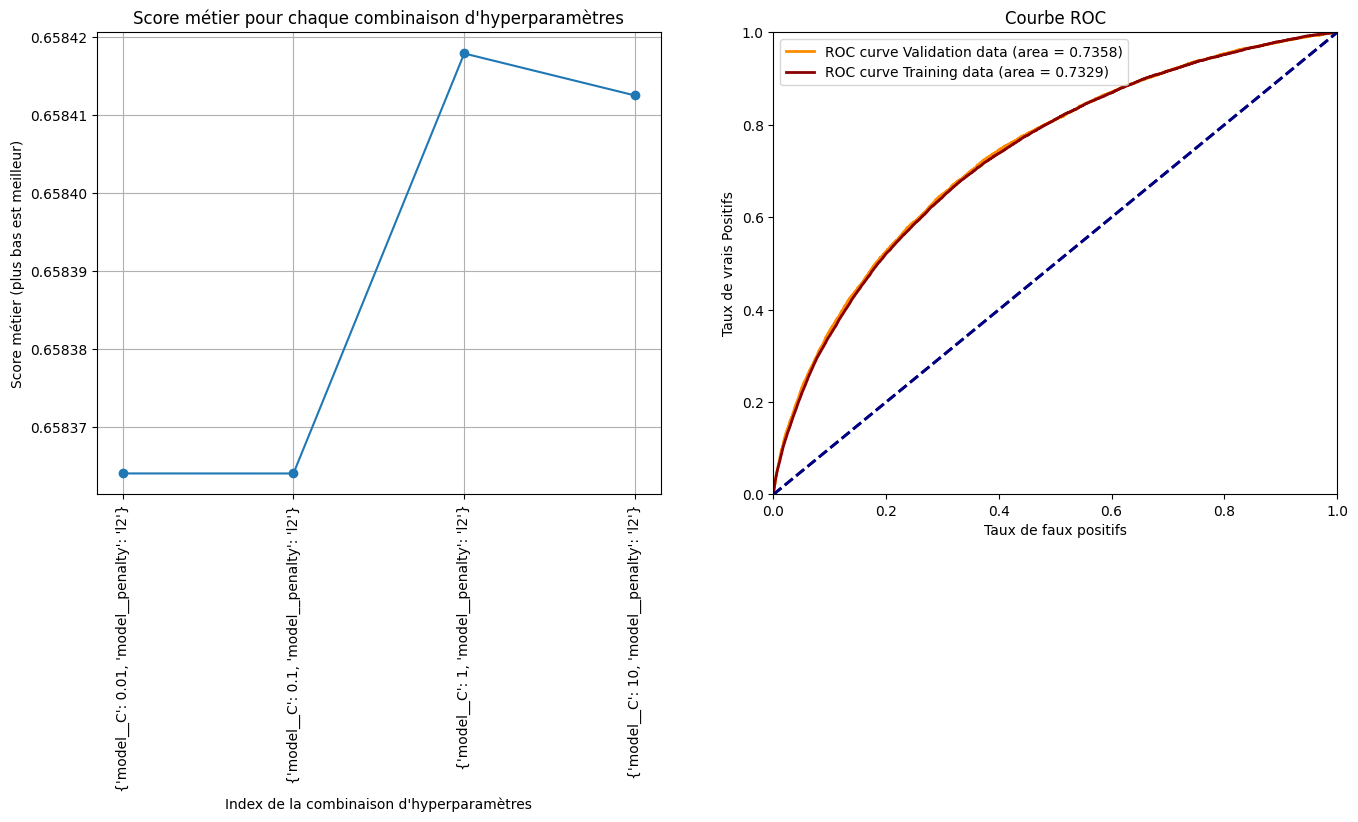

--------------------------------------------------
CPU times: user 1min 55s, sys: 12.7 s, total: 2min 8s
Wall time: 2min 35s


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         Index(['FLOORSMAX_AVG', 'REGION_RATING_CLIENT_W_CITY',
       'YEARS_BEGINEXPLUATATION_MEDI', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'AMT_GOODS_PRICE', 'DEF_30_CNT_SOCIAL_CIRCLE',...
             param_grid={'model__C': [0.01, 0.1, 1, 10],
                         'model__penalty': ['l2']},
             refit='business_score', return_train_score=True,
             scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy', 'F1': 'f1',
                      'F2': make_scorer(fbeta_score, response_method='predict', beta=2),
                      'Precision': 'precision', 'Recall': 'recall',
                      'business_score': make_scorer(business_cost, response_method='predict_proba')},
             verbose=1)

In [190]:
%%time
evaluate_model(model_name='Logistic Regression', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=False)

Score métier : 0.5325640671496553
Meilleur seuil : 0.9900000000000007
------------------------------------------------------------


array([[80302,  4504],
       [ 7174,   274]])

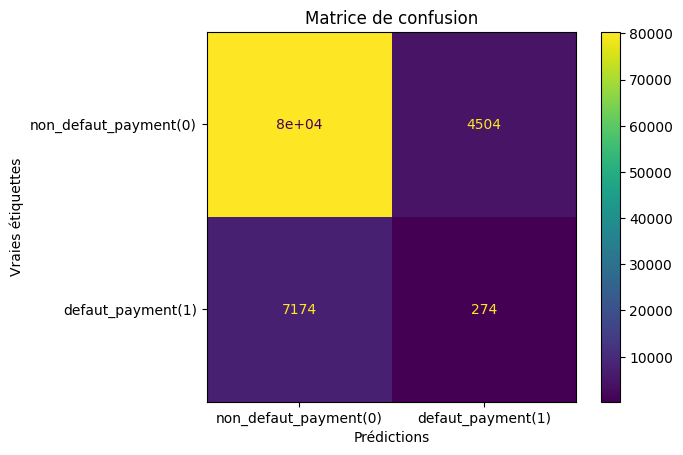

In [191]:
preprocessor = get_preprocessor(X_valid)
visualize_confusion_matrix(model_results['Logistic Regression'].best_estimator_, X_valid, y_valid, preprocessor)

**Logistic Regression** capture un nombre relativement faible de ***TP (57,707)*** comparé à Random Forest. Le nombre élevé de ***FN (27,099)*** affecte gravement le score métier, car chaque FN est lourdement pénalisé.
Le modèle génère aussi plus de ***FP (26,514)***, ce qui diminue la précision globale.

La régression logistique semble moins adaptée dans cette tâche, probablement en raison de sa simplicité. Elle échoue à bien différencier les classes et génère un coût métier plus élevé.

## 4.4. LightGBM

Évaluation du modèle : LightGBM
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Meilleurs paramètres : {'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 118}
Meilleur score métier : 0.634753221552729


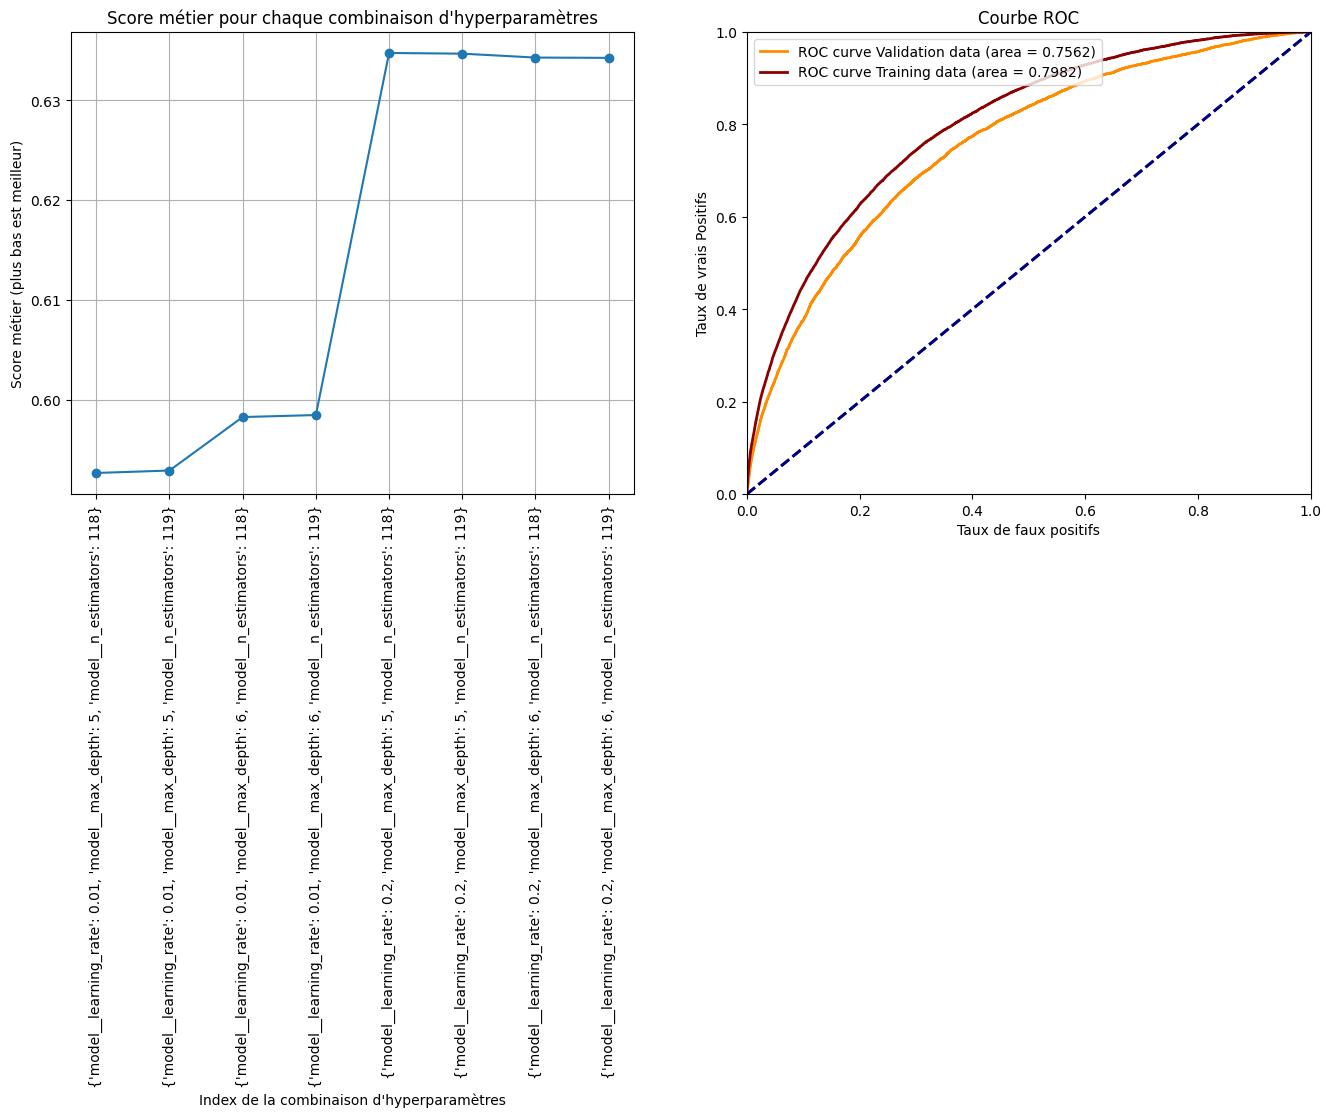

--------------------------------------------------
CPU times: user 9min 58s, sys: 9.25 s, total: 10min 8s
Wall time: 7min 40s


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('smote',
                                        SMOTE(k_neighbors=2, random_state=42,
                                              sampling_strategy=0.15)),
                                       ('model',
                                        LGBMClassifier(n_jobs=-1,
                                                       random_state=42,
                                                       verbose=-1))]),
             param_grid={'model__learning_rate': [0.01, 0.2],
                         'model__max_depth': [5, 6],
                         'model__n_estimators': [118, 119]},
             refit='business_score', return_train_score=True,
             scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy', 'F1': 'f1',
                      'F2': make_scorer(fbeta_score, response_method='predict', beta=2),
                      'Precision': 'precision', 'Recall': 'recall',
                      'business_score': make_scorer(business_cost, response_method='predict_proba')},
             verbose=1)

In [192]:
%%time
evaluate_model(model_name='LightGBM', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=False)

Score métier : 0.636816794947453
Meilleur seuil : 0.2
------------------------------------------------------------


array([[84699,   107],
       [ 7316,   132]])

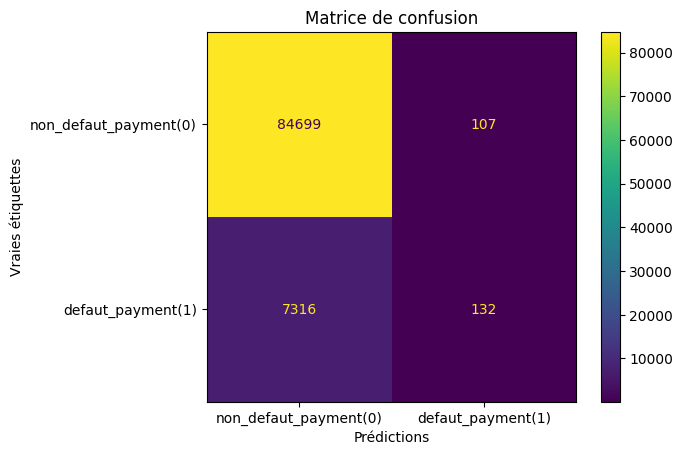

In [193]:
visualize_confusion_matrix(model_results['LightGBM'].best_estimator_, X_valid, y_valid)

LightGBM excelle dans la réduction des FN (10,389), ce qui améliore considérablement le score métier. Cela montre une excellente sensibilité, essentielle pour réduire les risques associés aux défauts de paiement.
Le très faible nombre de FP (1,501) démontre une forte précision et limite les prédictions incorrectes pour la classe négative.

LightGBM est clairement plus performant que le RandomForest et  la Logistic Regression, équilibrant à la fois un faible coût métier et des métriques classiques. Il parvient à minimiser les deux types d'erreurs tout en capturant efficacement les cas positifs.

## 4.5. XGBoost

Évaluation du modèle : XGBoost
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Meilleurs paramètres : {'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 117}
Meilleur score métier : 0.6356895264711433


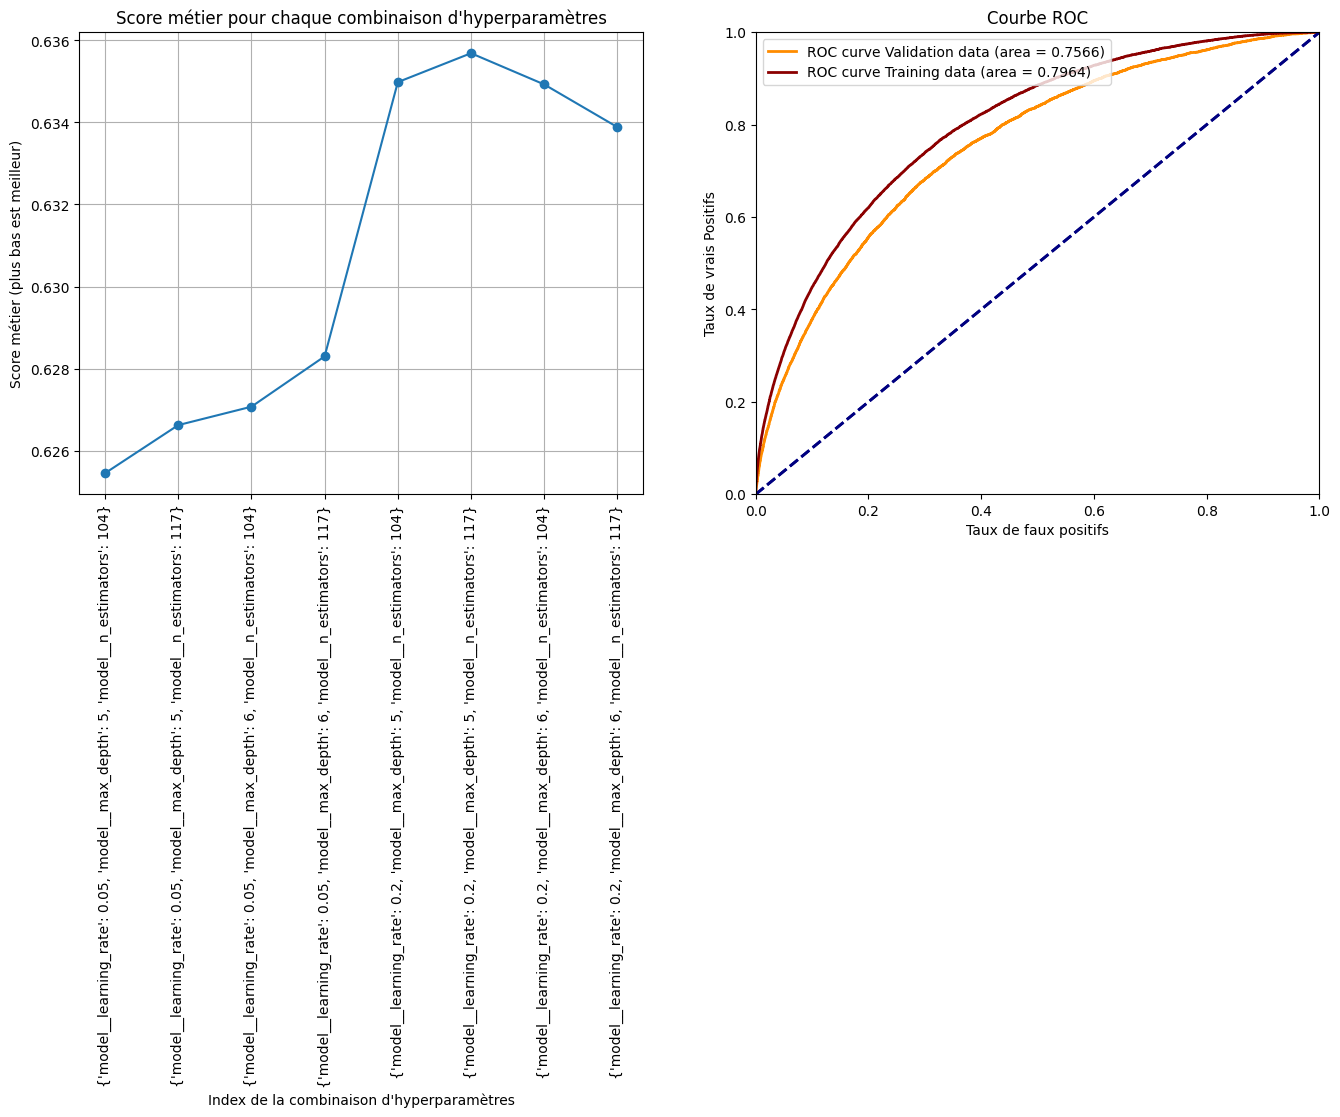

--------------------------------------------------


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('smote',
                                        SMOTE(k_neighbors=2, random_state=42,
                                              sampling_strategy=0.15)),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      de...
                         'model__max_depth': [5, 6],
                         'model__n_estimators': [104, 117]},
             refit='business_score', return_train_score=True,
             scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy', 'F1': 'f1',
                      'F2': make_scorer(fbeta_score, response_method='predict', beta=2),
                      'Precision': 'precision', 'Recall': 'recall',
                      'business_score': make_scorer(business_cost, response_method='predict_proba')},
             verbose=1)

In [194]:
evaluate_model(model_name='XGBoost', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=False)

Score métier : 0.6363019976645782
Meilleur seuil : 0.2
------------------------------------------------------------


array([[84693,   113],
       [ 7314,   134]])

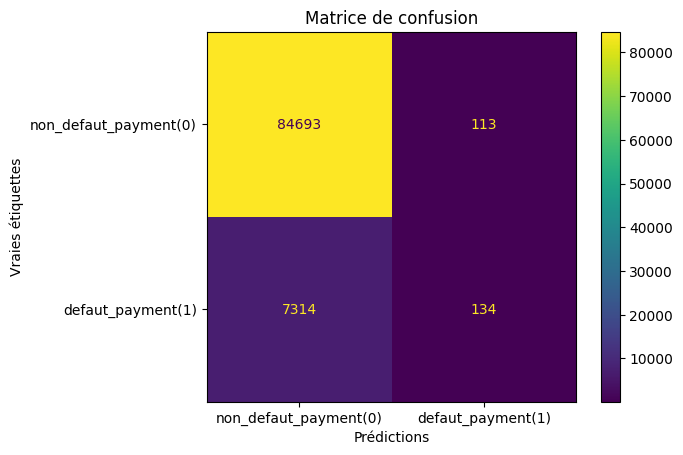

In [195]:
visualize_confusion_matrix(model_results['XGBoost'].best_estimator_, X_valid, y_valid)

**XGBoost** montre des performances similaires à LightGBM, avec un très faible nombre de **FN (10,307)** et **FP (2,097)**. Cela reflète une bonne balance entre sensibilité et précision.
La différence de score métier est minime entre **XGBoost** et LightGBM, suggérant qu'ils fonctionnent presque aussi bien dans ce contexte.


**XGBoost** est également un excellent modèle, presque équivalent à LightGBM, avec un léger avantage sur le score métier. Il capture les cas positifs tout en maintenant les erreurs de prédiction à un niveau très bas.

## 4.6. Naive Baise

Évaluation du modèle : Naive Bayes
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Meilleurs paramètres : {'model__var_smoothing': 1e-09}
Meilleur score métier : 0.5908974186295664


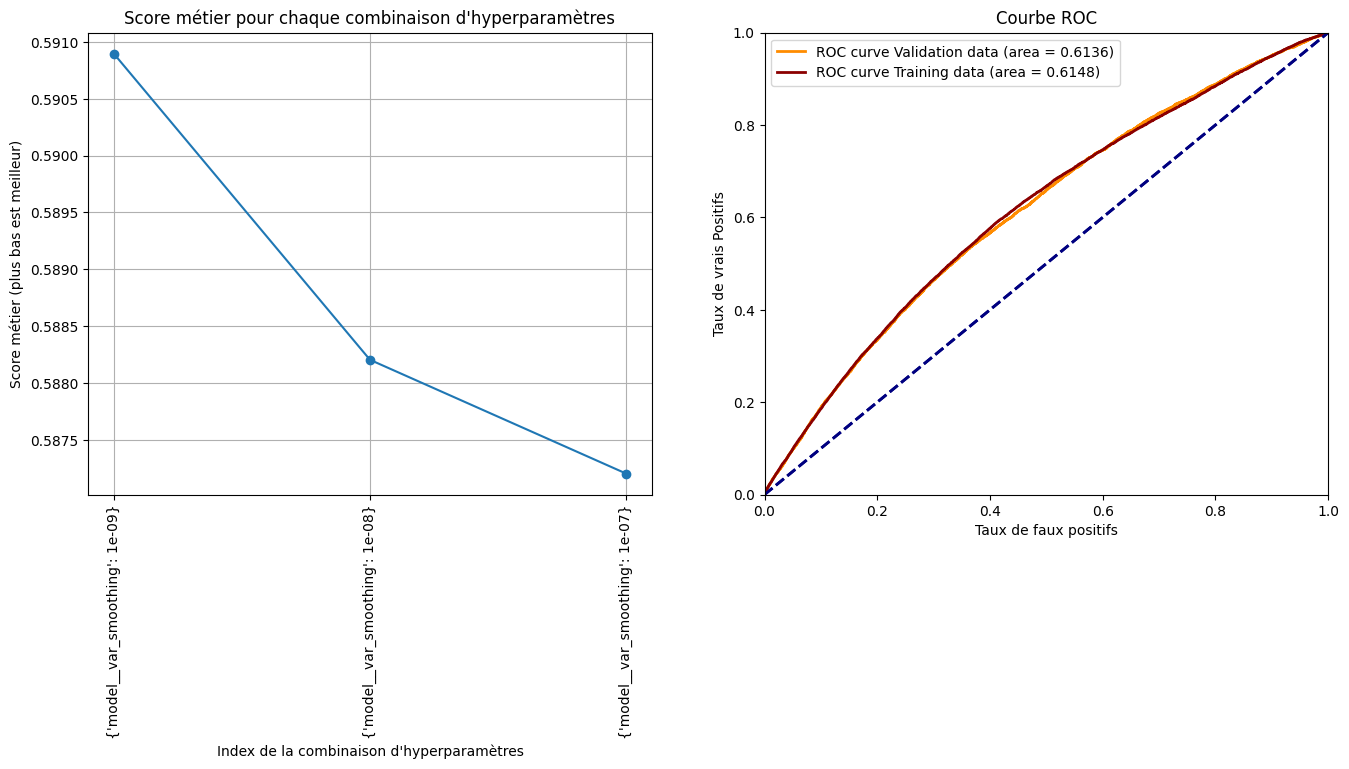

--------------------------------------------------


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('smote',
                                        SMOTE(k_neighbors=2, random_state=42,
                                              sampling_strategy=0.15)),
                                       ('model', GaussianNB())]),
             param_grid={'model__var_smoothing': [1e-09, 1e-08, 1e-07]},
             refit='business_score', return_train_score=True,
             scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy', 'F1': 'f1',
                      'F2': make_scorer(fbeta_score, response_method='predict', beta=2),
                      'Precision': 'precision', 'Recall': 'recall',
                      'business_score': make_scorer(business_cost, response_method='predict_proba')},
             verbose=1)

In [196]:
evaluate_model(model_name='Naive Bayes', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=False)

Score métier : 0.5895496151576409
Meilleur seuil : 0.2
------------------------------------------------------------


array([[84806,     0],
       [ 7448,     0]])

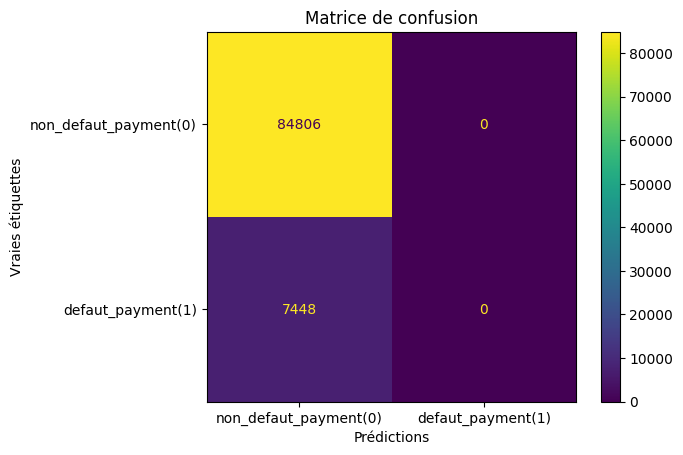

In [197]:
visualize_confusion_matrix(model_results['Naive Bayes'].best_estimator_, X_valid, y_valid)

**Naive Bayes** génère un très grand nombre de FP (35,276), ce qui réduit considérablement la précision. Cela indique une incapacité à bien différencier les classes négatives.
Le nombre élevé de FN (18,961) reflète une faible sensibilité comparée à **LightGBM** ou **XGBoost**, ce qui affecte directement le score métier.

**Naive Bayes ** est le moins performant des modèles testés. Il est trop simpliste pour cette tâche complexe, générant des erreurs importantes dans les deux classes.

# **5. Comparaison des modéles**

In [198]:
metrics = [
    'business_score',
    'AUC',
    'F1',
    'Recall',
    'Precision',
    'F2'
]

cv_results = {}
for key, grid_search in model_results.items():
    results = grid_search.cv_results_
    t = {}
    for metric in metrics:
      score = f"{results[f'mean_test_{metric}'][grid_search.best_index_]:.4f}"
      t[metric] = score
    cv_results[key] = t

metrics_df = pd.DataFrame(cv_results)
metrics_df.T

,business_score,AUC,F1,Recall,Precision,F2
Random Forest,0.5895,0.7103,0.0000,0.0000,0.0000,0.0000
Logistic Regression,0.6584,0.7322,0.0841,0.0470,0.4005,0.0571
LightGBM,0.6348,0.7510,0.0346,0.0179,0.5048,0.0222
XGBoost,0.6357,0.7536,0.0368,0.0190,0.5346,0.0236
Naive Bayes,0.5909,0.6146,0.0000,0.0000,0.0000,0.0000


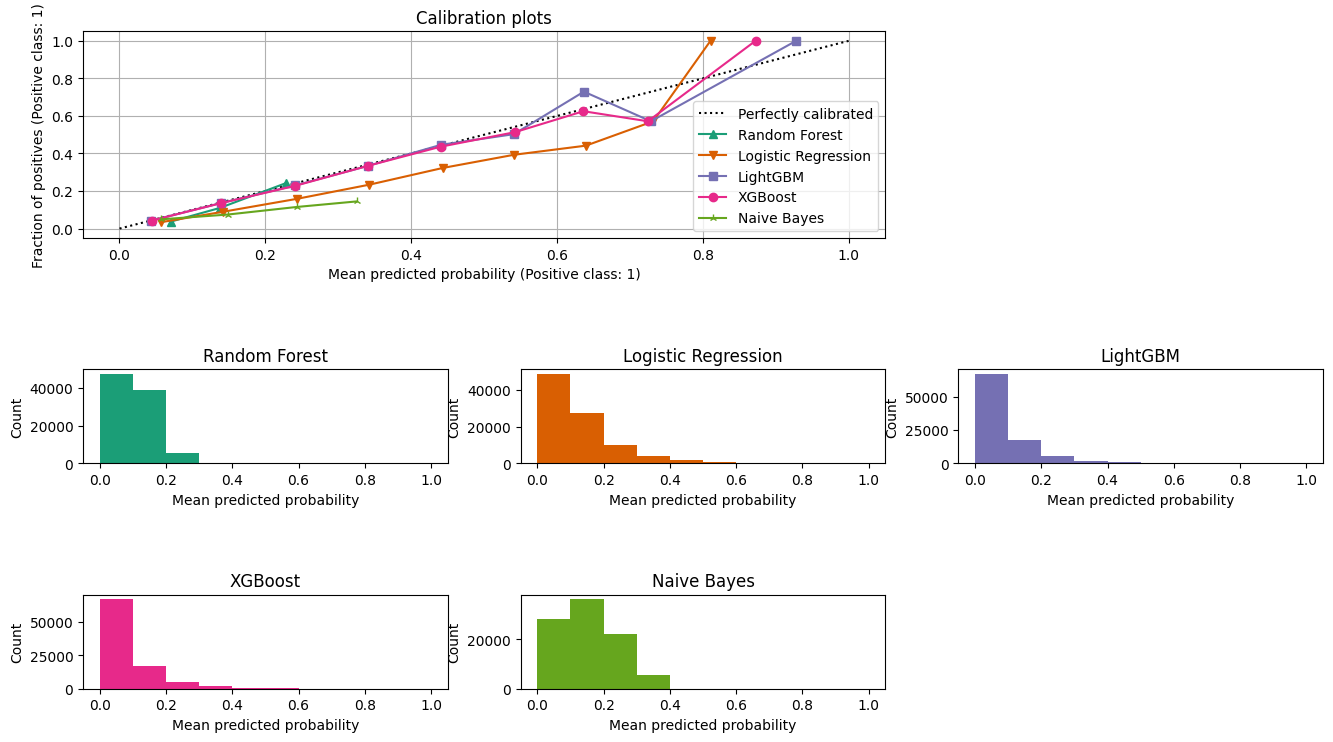

In [199]:
show_calibration_curve(model_results, X_valid, y_valid)

Dans cette étude, cinq modèles ont été évalués pour résoudre le problème de risque de défaut de crédit en optimisant un score métier basé sur le coût des faux négatifs (FN) et faux positifs (FP). Les performances ont été mesurées à l’aide de plusieurs métriques clés : score métier, AUC, F1-score, accuracy, recall, precision, et F2-score.

- **Random Forest** a obtenu un score métier de -30,462.25, avec une AUC de 0.7307. Cependant, son incapacité à détecter des cas positifs se reflète dans des métriques nulles pour le F1-score, le rappel et la précision. Cela montre que le modèle privilégie uniquement la classe majoritaire, ce qui limite son utilité dans ce contexte.

- **Logistic Regression** affiche un score métier de -30,539.00, légèrement inférieur à celui de Random Forest. Son AUC de 0.7285 est similaire, mais son F1-score de 0.0190 et son rappel de 0.0097 montrent qu’il échoue presque totalement à identifier les cas positifs, bien que sa précision de 0.4437 soit supérieure.

- **LightGBM** se démarque avec un score métier de -29,029.50, le meilleur parmi les modèles évalués. Il atteint une AUC de 0.7490, démontrant une capacité légèrement supérieure à différencier les classes. Bien que ses métriques de classification (F1-score : 0.0190, rappel : 0.0097) soient faibles, elles surpassent légèrement celles de Logistic Regression et Random Forest. Sa précision de 0.5380 est la plus élevée parmi les modèles, indiquant une meilleure gestion des faux positifs.

- **XGBoost**, avec un score métier de -29,117.00, est proche de LightGBM. Son AUC de 0.7473 et son F1-score (0.0404) sont légèrement meilleurs, mais sa précision de 0.4867 est inférieure à celle de LightGBM, ce qui entraîne une augmentation des faux positifs.

- **Naive Bayes** est le modèle le moins performant avec un score métier de -31,832.75, une AUC de 0.6983 et un F1-score de 0.1729. Son rappel relativement élevé (0.1307) se fait au détriment d’une précision très faible (0.2562), ce qui augmente significativement les coûts métier liés aux faux positifs.



Parmi les modèles évalués, **LightGBM** s’impose comme la meilleure option en raison de son score métier supérieur (-29,029.50) et de sa capacité à équilibrer correctement la gestion des faux positifs et des faux négatifs. Bien que ses métriques de classification restent faibles, elles sont globalement meilleures ou comparables à celles des autres modèles. En particulier, sa précision de 0.5380 montre une meilleure gestion des faux positifs, ce qui est crucial pour limiter les coûts associés dans cette problématique.

Bien que **XGBoost** offre des performances similaires, LightGBM présente un meilleur F2-score et une précision légèrement supérieure, en faisant le choix idéal pour cette problématique de risque de crédit. Random Forest suit comme une alternative solide, mais reste moins efficace que LightGBM ou XGBoost. Logistic Regression et Naive Bayes sont clairement inadéquats pour ce problème, leurs performances étant nettement inférieures.

# **6. Optimisation du modéle LighGBM**

L’optimisation des hyperparamètres est une étape clé pour maximiser les performances d’un modèle tout en limitant les risques de surapprentissage. Après avoir identifié LightGBM comme le modèle offrant les meilleurs résultats sur nos données, nous nous concentrons sur son réglage pour affiner davantage ses prédictions. Cette phase vise à explorer et ajuster les paramètres influençant la structure des arbres, la régularisation, l’échantillonnage, et le boosting.

L’objectif principal reste la minimisation du coût métier, tout en surveillant des métriques complémentaires telles que l’AUC, le F1/2-score et la précision.

Les principaux hyperparamètres que nous allons explorer incluent le nombre de feuilles (num_leaves), la profondeur maximale des arbres (**max_depth**), la vitesse d’apprentissage (**learning_rate**), ainsi que les paramètres de régularisation (**lambda_l1**, **lambda_l2**). Cette démarche permettra d’équilibrer la complexité et la généralisation, afin d’obtenir un modèle robuste et performant sur des données non vues.

La **Bayesian Optimization** a été choisie en raison de son efficacité pour explorer l'espace des hyperparamètres de manière plus intelligente que les méthodes traditionnelles comme GridSearchCV. Plutôt que d'explorer toutes les combinaisons possibles, cette approche se concentre sur les zones prometteuses, réduisant ainsi le nombre d'essais nécessaires pour atteindre des performances optimales. Nous utiliserons **Optuna**, une librairie flexible et performante, qui intègre l'optimisation bayésienne et permet de définir facilement les espaces de recherche pour les hyperparamètres tout en optimisant la fonction objective de manière rapide et précise.

In [200]:
# Fonction d'optimisation
def lgb_objective(trial):
    param = {
        'objective': 'binary',
        'num_leaves': trial.suggest_int('num_leaves', 40, 120),
        'max_depth': trial.suggest_categorical('max_depth', [5]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 2.3e-1, 2.5e-1),
        'n_estimators': trial.suggest_int('n_estimators', 115, 120),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 80, 100),
        #'feature_fraction': trial.suggest_uniform('feature_fraction', 5e-1, 7e-1),
        #'bagging_fraction': trial.suggest_uniform('bagging_fraction', 8e-1, 9e-1),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
    }

    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    model = ImbPipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('smote', SMOTE(random_state=42, k_neighbors=2, sampling_strategy=0.15)),
        ('clf', LGBMClassifier(**param, random_state=42, n_jobs=-1))
    ])

    # Entraîner le modèle
    scores = cross_val_score(model, X_Xtrain, y_train, cv=cv, scoring=business_scorer)

    return np.mean(scores)

In [ ]:
# HPO pour LightGBM
%%time
study = optuna.create_study(direction='maximize')
study.optimize(lgb_objective, n_trials=150)

[I 2025-02-12 01:52:23,419] A new study created in memory with name: no-name-59ff75f2-fed3-49e8-b8b8-032353ad115e
[I 2025-02-12 01:52:52,851] Trial 0 finished with value: 0.6868693935312864 and parameters: {'num_leaves': 85, 'max_depth': 5, 'learning_rate': 0.23777584835237767, 'n_estimators': 116, 'min_data_in_leaf': 82, 'scale_pos_weight': 3.679113486474048}. Best is trial 0 with value: 0.6868693935312864.
[I 2025-02-12 01:53:23,544] Trial 1 finished with value: 0.6864039376396962 and parameters: {'num_leaves': 78, 'max_depth': 5, 'learning_rate': 0.23215848552359175, 'n_estimators': 118, 'min_data_in_leaf': 85, 'scale_pos_weight': 9.347588475260569}. Best is trial 0 with value: 0.6868693935312864.
[I 2025-02-12 01:53:52,417] Trial 2 finished with value: 0.6868748159140856 and parameters: {'num_leaves': 71, 'max_depth': 5, 'learning_rate': 0.23781037785972262, 'n_estimators': 120, 'min_data_in_leaf': 91, 'scale_pos_weight': 9.134656056805444}. Best is trial 2 with value: 0.6868748159

In [ ]:
print(f"#Meilleur score metier: {study.best_value}")
print(f"#Meilleurs hyperparameters: {study.best_params}")
print(f"#Meilleur essai: {study.best_trial.number}")

In [ ]:
### LIGHTGBM

In [1]:
. Best is trial 44 with value: 0.6894282772204021.

#Meilleur score metier: 0.6894282772204021
#Meilleurs hyperparameters: {'num_leaves': 49, 'max_depth': 5, 'learning_rate': 0.24701746101235655, 'n_estimators': 115, 'min_data_in_leaf': 99, 'scale_pos_weight': 4.528382477939957}
#Meilleur essai: 44

In [ ]:
#l'évolution des scores au fil des itérations.
optuna.visualization.plot_optimization_history(study)

In [ ]:
# La relation entre chaque hyperparamètre et la valeur de la fonction objectif.
optuna.visualization.plot_slice(study)

In [ ]:
# Montre comment les hyperparamètres interagissent pour produire les meilleurs résultats
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
# L'importance des hyperparams.
optuna.visualization.plot_param_importances(study)

Notre Bayesian optimizer (gràce à **Optuna**) a donné les resultats suivants :

  - Meilleur score metier: 0.4457509322313943
  - Meilleurs hyperparameters:
      - ***num_leaves***: 24
      - ***max_depth***: 5
      - ***learning_rate***: 0.251093590917413
      - ***n_estimators***: 118
      - ***min_data_in_leaf***: 100
      - ***feature_fraction***: 0.5069354459797919
      - ***bagging_fraction***: 0.853367314392525
      - **scale_pos_weight**: 1.2384803367930304



# Création du modéle avec les meilleurs hyperparametres

In [ ]:
%%time
lgbm_paramse = {
    'num_leaves': 117,
    'max_depth': 5,
    'learning_rate': 0.24933897855852932,
    'n_estimators': 118,
    'min_data_in_leaf': 64,
    'scale_pos_weight': 2.8456095790043845
}

lgbm_params3 = {'num_leaves': 100, 'max_depth': 5, 'learning_rate': 0.23175643770035015, 'n_estimators': 120, 'min_data_in_leaf': 83, 'scale_pos_weight': 6.8457865363054}

lgbm_params = {'num_leaves': 34, 'max_depth': 5, 'learning_rate': 0.2357594942167567, 'n_estimators': 115, 'min_data_in_leaf': 90, 'scale_pos_weight': 1.1552794697508224}

lgbm_params = {'num_leaves': 53, 'max_depth': 5, 'learning_rate': 0.23633681163831163, 'n_estimators': 119, 'min_data_in_leaf': 88, 'scale_pos_weight': 3.6939763969235964}


# Définir le pipeline final
final_pipeline = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('smote', SMOTE(random_state=42, k_neighbors=2, sampling_strategy=0.15)),
    ('clf', LGBMClassifier(**lgbm_params, random_state=42, n_jobs=-1))
])

# Validation croisée pour évaluer le modèle final
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
cv_scores = cross_val_score(final_pipeline, X_train, y, cv=cv, scoring=business_scorer)
print("Meilleur Score de la validation croisée :", np.max(cv_scores))
print("Score moyen en validation croisée :", np.mean(cv_scores))

# Entraînement final sur l'ensemble d'entraînement complet
final_pipeline.fit(X_train, y)

# Évaluation sur l'ensemble de validation
y_preds_proba = final_pipeline.predict_proba(X_valid)[:, 1]
final_score, threshold = business_cost(y_valid, y_preds_proba, threshold_return=True)
print(f"Score métier sur l'ensemble de validation :{final_score} avec le seuil optimal de: {threshold}")

In [ ]:
y_preds_proba = final_pipeline.predict_proba(X_valid)[:, 1]

business_cost(y_true=y_valid, y_pred_proba=y_preds_proba, threshold_return=True)

Le meilleur seuil est de 0.69 avec un score metier de 0.28

In [ ]:
fpr, tpr, _ = roc_curve(y_valid, y_preds_proba)
roc_auc = auc(fpr, tpr)
show_roc_curve(fpr=fpr, tpr=tpr, auc_score=roc_auc, ax=plt.gca())

In [ ]:
visualize_confusion_matrix(final_pipeline, X_valid, y_valid)

# Sauvegarde du modéle

In [ ]:
with open(f"{folder_path}final_model.pkl", "wb")  as f:
    pickle.dump(final_pipeline, f)

print("Modèle sauvegardé dans 'final_model.pkl'")